In [3]:
# ============================================================
# CELL 0 — Install (RUN ONCE)
# ============================================================
!pip -q install mediapy lovely-tensors tqdm einops opencv-python matplotlib torchmetrics hydra-core timm huggingface_hub transformers scikit-learn psutil
!pip -q install git+https://github.com/facebookresearch/segment-anything.git


  Preparing metadata (setup.py) ... done


In [ ]:
# ============================================================
# CELL 1 — Imports + Colab Drive + HF Login
# ============================================================
import os, math, time, datetime, logging
import numpy as np
import cv2
import matplotlib.pyplot as plt
import mediapy as mp

import torch
import torch.nn.functional as F
import torchvision.transforms as TVT
import torchvision.transforms.functional as TVTF
from torch import Tensor, nn
from tqdm import tqdm
from PIL import Image

import psutil

DISPLAY_HEIGHT = 220
torch.set_grad_enabled(False)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def ram_gb():
    return psutil.Process(os.getpid()).memory_info().rss / 2**30

print("RAM GB:", ram_gb())

from google.colab import drive
drive.mount('/content/drive')

from huggingface_hub import login
login()  # paste HF token when asked


In [5]:
# ============================================================
# CELL 2 — Load DINOv3 (HuggingFace Transformers, CPU)
# ============================================================
from transformers import AutoImageProcessor, AutoModel

processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m")
model = AutoModel.from_pretrained("facebook/dinov3-vitl16-pretrain-lvd1689m")

model.to("cpu")
model.eval()

patch_size = 16
embed_dim = model.config.hidden_size

print("Model loaded on:", next(model.parameters()).device)
print(f"Patch size: {patch_size}")
print(f"Embedding dimension: {embed_dim}")
print("RAM GB:", ram_gb())

def forward(model, img: torch.Tensor) -> torch.Tensor:
    """
    img: [3,H,W] or [1,3,H,W] normalized tensor
    returns: [h,w,D]
    """
    if img.ndim == 3:
        img = img.unsqueeze(0)

    with torch.no_grad():
        outputs = model(pixel_values=img)

    last_hidden = outputs.last_hidden_state  # [1, tokens, D]
    num_reg = getattr(model.config, "num_register_tokens", 0)
    patch_tokens = last_hidden[:, 1 + num_reg :, :]

    _, _, H, W = img.shape
    H_p = H // patch_size
    W_p = W // patch_size

    patch_grid = patch_tokens.reshape(1, H_p, W_p, -1)
    return patch_grid.squeeze(0)  # [h,w,D]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Model loaded on: cpu
Patch size: 16
Embedding dimension: 1024
RAM GB: 1.0498275756835938


Frames: 12 | first size: (3840, 2160)


Frame 0,Frame 3,Frame 7,Frame 11

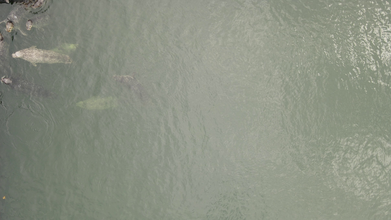
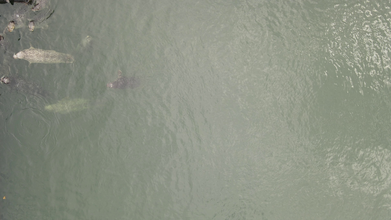
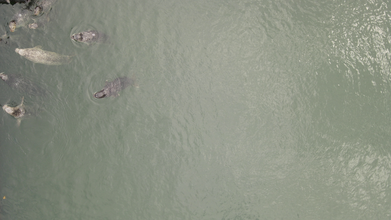
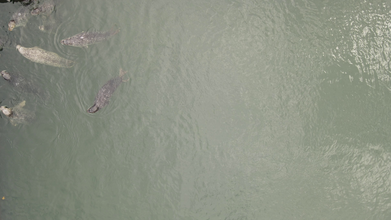

Mask size: (2160, 3840)


Frame 0,First mask (class),First mask (components)

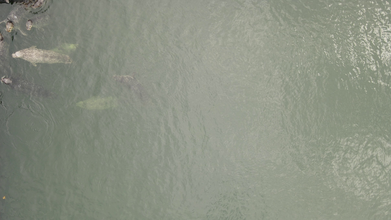
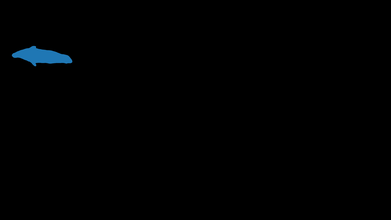
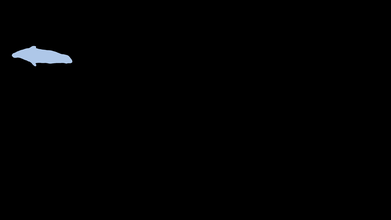

In [6]:
# ============================================================
# CELL 3 — Load frames + first mask + helpers  (UPDATED)
#   - Added colorize_components() so you can SEE multiple seals as different colors
#   - Kept your existing mask_to_rgb (still used for 2-class if you want)
# ============================================================
VIDEO_NAME = "DJI_0001"
FRAMES_DIR = f"/content/drive/MyDrive/seal_project/frames/{VIDEO_NAME}"
MASK_PATH  = f"/content/drive/MyDrive/seal_project/masks/{VIDEO_NAME}_mask.png"

frames = [
    Image.open(os.path.join(FRAMES_DIR, f)).convert("RGB")
    for f in sorted(os.listdir(FRAMES_DIR))
    if f.lower().endswith((".jpg", ".png"))
]
num_frames = len(frames)
print("Frames:", num_frames, "| first size:", frames[0].size)

# preview
idxs = np.linspace(0, num_frames-1, 4, dtype=int)
mp.show_images([frames[i] for i in idxs], titles=[f"Frame {i}" for i in idxs], height=DISPLAY_HEIGHT)

def mask_to_rgb(mask: np.ndarray | torch.Tensor, num_masks: int) -> np.ndarray:
    """Class-coloring (for num_masks classes). With num_masks=2 it's just one color for 'seal'."""
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    background = mask == 0
    mask2 = mask - 1
    M = num_masks - 1

    if M <= 10:
        rgb = plt.get_cmap("tab10")(mask2)[..., :3]
    elif M <= 20:
        rgb = plt.get_cmap("tab20")(mask2)[..., :3]
    else:
        rgb = plt.get_cmap("gist_rainbow")(mask2 / max(1, (M - 1)))[..., :3]

    rgb = (rgb * 255).astype(np.uint8)
    rgb[background] = 0
    return rgb

def colorize_components(binary_mask: np.ndarray | torch.Tensor) -> np.ndarray:
    """
    Instance-like visualization for a binary mask:
    each connected component gets a different color.
    This does NOT change your training/logic, only visualization.
    """
    if isinstance(binary_mask, torch.Tensor):
        binary_mask = binary_mask.cpu().numpy()
    m = (binary_mask > 0).astype(np.uint8)
    n, labels = cv2.connectedComponents(m)  # 0=bg, 1..n-1 components
    if n <= 1:
        return np.zeros((*m.shape, 3), dtype=np.uint8)

    rgb = plt.get_cmap("tab20")((labels % 20) / 20.0)[..., :3]
    rgb = (rgb * 255).astype(np.uint8)
    rgb[labels == 0] = 0
    return rgb

first_mask_np = np.array(Image.open(MASK_PATH).convert("L"))
first_mask_np = (first_mask_np > 0).astype(np.int64)

mask_height, mask_width = first_mask_np.shape
num_masks = 2  # {0 background, 1 seal(union)}
print("Mask size:", (mask_height, mask_width))

mp.show_images(
    [frames[0], mask_to_rgb(first_mask_np, num_masks), colorize_components(first_mask_np)],
    titles=["Frame 0", "First mask (class)", "First mask (components)"],
    height=DISPLAY_HEIGHT
)


Frames: 12 | first size: (3840, 2160)


Frame 0,Frame 3,Frame 7,Frame 11

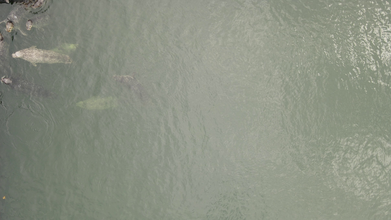
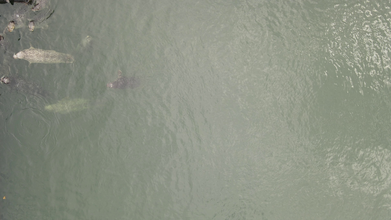
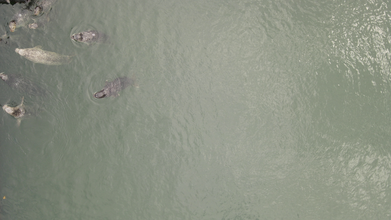
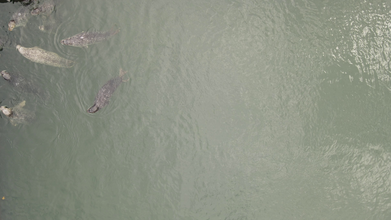

In [7]:
VIDEO_NAME = "DJI_0001"
FRAMES_DIR = f"/content/drive/MyDrive/seal_project/frames/{VIDEO_NAME}"

frames = [
    Image.open(os.path.join(FRAMES_DIR, f)).convert("RGB")
    for f in sorted(os.listdir(FRAMES_DIR))
    if f.lower().endswith((".jpg", ".png"))
]
num_frames = len(frames)
print("Frames:", num_frames, "| first size:", frames[0].size)

# preview
idxs = np.linspace(0, num_frames-1, 4, dtype=int)
mp.show_images([frames[i] for i in idxs], titles=[f"Frame {i}" for i in idxs], height=DISPLAY_HEIGHT)


In [14]:
# ============================================================
# CELL 5 — Propagation (COSINE similarity)
# ============================================================
@torch.compile(disable=True)
def propagate(
    current_features: Tensor,      # [h, w, D]
    context_features: Tensor,      # [t, h, w, D]
    context_probs: Tensor,         # [t, h, w, M]
    neighborhood_mask: Tensor,     # [h, w, h, w] (all True => pure cosine)
    topk: int,
    temperature: float,
) -> Tensor:
    t, h, w, M = context_probs.shape

    current_norm = F.normalize(current_features, dim=-1)
    context_norm = F.normalize(context_features, dim=-1)

    dot = torch.einsum("ijd, tuvd -> ijtuv", current_norm, context_norm)
    dot = torch.where(neighborhood_mask[:, :, None, :, :], dot, -torch.inf)

    dot = dot.flatten(2, -1).flatten(0, 1)                 # [h*w, t*h*w]
    k_th = torch.topk(dot, dim=1, k=topk).values[:, -1:]   # [h*w,1]
    dot = torch.where(dot >= k_th, dot, -torch.inf)

    weights = F.softmax(dot / temperature, dim=1)
    current_probs = torch.mm(weights, context_probs.flatten(0, 2))
    current_probs = current_probs / current_probs.sum(dim=1, keepdim=True)

    return current_probs.unflatten(0, (h, w))              # [h,w,M]

print("Cosine propagation ready ✅")


Cosine propagation ready ✅


In [9]:
# ============================================================
# CELL 6 — Load SAM ViT-B + Guided Tiled SAM (RAM-safe + less glints)
# ============================================================
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import urllib.request

DEVICE = "cpu"
sam_checkpoint = "/content/sam_vit_b_01ec64.pth"
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"

if not os.path.exists(sam_checkpoint):
    print("Downloading SAM ViT-B checkpoint...")
    urllib.request.urlretrieve(url, sam_checkpoint)
    print("Downloaded:", sam_checkpoint)
else:
    print("SAM checkpoint exists:", sam_checkpoint)

sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(DEVICE).eval()
print("SAM loaded ✅ on", DEVICE)

# Main SAM generator (kept reasonably strict)
sam_mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,            # faster than 32
    pred_iou_thresh=0.90,
    stability_score_thresh=0.90,
    min_mask_region_area=150,
)

# Filters + tiling
SAM_MIN_AREA = 300
SAM_MAX_AREA = 20000
SAM_TILE   = 512
SAM_STRIDE = 384

# Guidance parameters (Fix 2)
SAM_GUIDE_MIN_OVERLAP = 0.12   # 0.05–0.20 (higher = stricter)
SAM_GUIDE_DILATE_PX   = 25     # 10–60 depending on motion / resolution

def sam_redetect_binary_mask_filtered_tiled_guided(
    frame_pil,
    out_h,
    out_w,
    guidance_mask_small=None,        # (out_h, out_w) 0/1 uint8 mask from current pred
    min_overlap=SAM_GUIDE_MIN_OVERLAP,
    guide_dilate_px=SAM_GUIDE_DILATE_PX,
    min_area=SAM_MIN_AREA,
    max_area=SAM_MAX_AREA,
    tile=SAM_TILE,
    stride=SAM_STRIDE,
):
    """
    Guided SAM re-detect (Fix 2):
      - Resize predicted mask to full frame
      - (Optional) dilate it so slight movement still covered
      - Run SAM per tile ONLY where guidance exists
      - Keep SAM masks only if enough overlap with guidance
    Returns: binary mask (0/1) in (out_h,out_w)
    """
    img_np = np.array(frame_pil.convert("RGB"))
    H, W = img_np.shape[:2]

    guidance_full = None
    if guidance_mask_small is not None:
        g = guidance_mask_small.astype(np.uint8)
        guidance_full = cv2.resize(g, (W, H), interpolation=cv2.INTER_NEAREST)

        if guide_dilate_px and guide_dilate_px > 0:
            k = int(guide_dilate_px)
            if k % 2 == 0:
                k += 1
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
            guidance_full = cv2.dilate(guidance_full, kernel, iterations=1)

    merged_full = np.zeros((H, W), dtype=np.uint8)
    total_masks = 0
    kept = 0
    skipped_tiles = 0

    for y0 in range(0, H, stride):
        for x0 in range(0, W, stride):
            y1 = min(y0 + tile, H)
            x1 = min(x0 + tile, W)

            # Skip tiles with no guidance pixels (big speedup + avoids glints)
            if guidance_full is not None:
                g_crop = guidance_full[y0:y1, x0:x1]
                if int(g_crop.sum()) == 0:
                    skipped_tiles += 1
                    continue
            else:
                g_crop = None

            crop = img_np[y0:y1, x0:x1]
            anns = sam_mask_generator.generate(crop)
            total_masks += len(anns)

            for a in anns:
                seg = a["segmentation"].astype(np.uint8)
                area = int(seg.sum())
                if not (min_area <= area <= max_area):
                    continue

                # Overlap filter = Fix 2 core
                if g_crop is not None:
                    overlap = int((seg & g_crop).sum())
                    if overlap / max(1, area) < min_overlap:
                        continue

                merged_full[y0:y1, x0:x1] = np.maximum(merged_full[y0:y1, x0:x1], seg)
                kept += 1

    merged = cv2.resize(merged_full, (out_w, out_h), interpolation=cv2.INTER_NEAREST)
    print(
        f"SAM guided tiled: total_masks={total_masks}, kept={kept}, "
        f"skipped_tiles={skipped_tiles}, merged_pixels={int(merged.sum())} | RAM GB:{ram_gb():.2f}"
    )
    return merged


SAM checkpoint exists: /content/sam_vit_b_01ec64.pth
SAM loaded ✅ on cpu


In [10]:
# ============================================================
# CELL 7 — Anchor init (first_feats + first_probs) ✅ UPDATED (NO ERRORS)
#   Fixes:
#   - define transform if missing (with REAL downscale for CPU)
#   - compute feats_height/feats_width AFTER first_feats
#   - then downsample mask correctly
# ============================================================

# --- 0) Safe transform (CPU-friendly) ---
# If you already defined transform before, this keeps it.
if "transform" not in globals():
    MAX_SIDE = 640  # 512/640 good for CPU; increase only if you move to GPU

    transform = TVT.Compose([
        TVT.Resize(MAX_SIDE),  # keeps aspect ratio, shortest side -> MAX_SIDE
        TVT.CenterCrop((
            (MAX_SIDE // patch_size) * patch_size,
            (MAX_SIDE // patch_size) * patch_size,
        )),
        TVT.ToTensor(),
        TVT.Normalize(mean=processor.image_mean, std=processor.image_std),
    ])
    print("Defined transform ✅ (CPU-friendly resize to", MAX_SIDE, ")")
else:
    print("Using existing transform ✅")

# --- 1) First frame -> DINO features ---
first_frame = transform(frames[0]).to("cpu")  # [3,H,W]
with torch.no_grad():
    first_feats = forward(model, first_frame)  # [h,w,D]

# --- 2) Feature map size (MUST be after first_feats) ---
feats_height, feats_width = first_feats.shape[:2]
print("Feature map size:", feats_height, feats_width)

# --- 3) First mask -> tensor ---
first_mask = torch.from_numpy(first_mask_np).to("cpu", dtype=torch.long)  # [Hmask,Wmask]

# --- 4) Downsample mask to feature resolution (nearest!) ---
first_mask_small = F.interpolate(
    first_mask[None, None].float(),            # [1,1,Hmask,Wmask]
    size=(feats_height, feats_width),
    mode="nearest",
)[0, 0].long()                                 # [h,w]

# --- 5) One-hot probs at feature resolution ---
first_probs = F.one_hot(first_mask_small, num_masks).float()  # [h,w,M]

print("first_frame:", tuple(first_frame.shape))
print("first_feats:", tuple(first_feats.shape), "| first_probs:", tuple(first_probs.shape))
print("RAM GB:", ram_gb())


Defined transform ✅ (CPU-friendly resize to 640 )
Feature map size: 40 40
first_frame: (3, 640, 640)
first_feats: (40, 40, 1024) | first_probs: (40, 40, 2)
RAM GB: 3.2520523071289062


SAM guided tiled: total_masks=25, kept=2, skipped_tiles=56, merged_pixels=11553 | RAM GB:3.39


Frame 2,SAM guided merged (tiled)

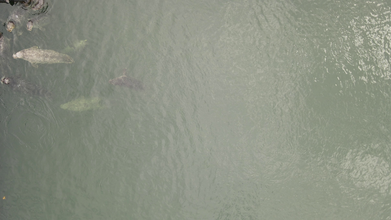
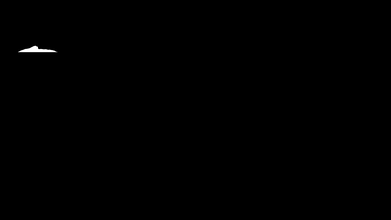

SAM guided tiled: total_masks=41, kept=9, skipped_tiles=56, merged_pixels=16166 | RAM GB:2.53


Frame 5,SAM guided merged (tiled)

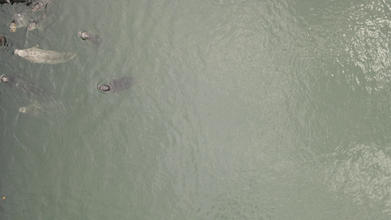
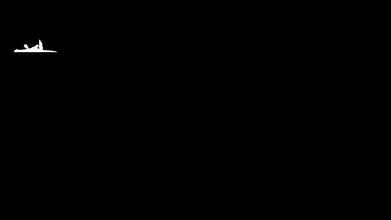

SAM guided tiled: total_masks=34, kept=8, skipped_tiles=56, merged_pixels=14639 | RAM GB:2.56


Frame 7,SAM guided merged (tiled)

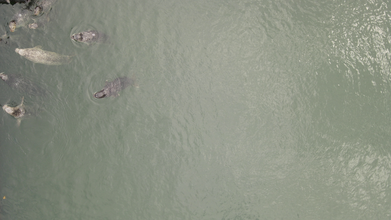
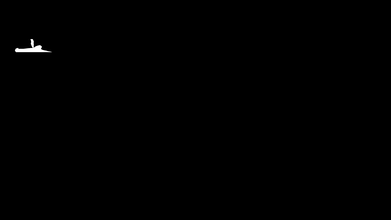

SAM guided tiled: total_masks=33, kept=4, skipped_tiles=56, merged_pixels=26116 | RAM GB:2.52


Frame 10,SAM guided merged (tiled)

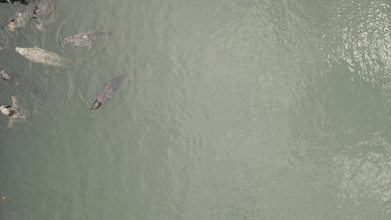
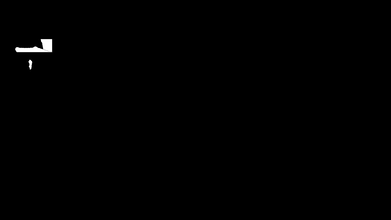

In [11]:
# ============================================================
# CELL 8 — Optional: Quick Guided SAM test on a few frames
# ============================================================

# Use the first labeled mask as guidance for preview (so it matches Fix 2 behavior)
guidance_preview = (first_mask_np == 1).astype(np.uint8)

for test_idx in [2, 5, 7, 10]:
    if test_idx >= num_frames:
        continue

    sam_mask_np = sam_redetect_binary_mask_filtered_tiled_guided(
        frames[test_idx],
        mask_height,
        mask_width,
        guidance_mask_small=guidance_preview,
        min_overlap=SAM_GUIDE_MIN_OVERLAP,
        guide_dilate_px=SAM_GUIDE_DILATE_PX,
    )

    mp.show_images(
        [frames[test_idx], sam_mask_np * 255],
        titles=[f"Frame {test_idx}", "SAM guided merged (tiled)"],
        height=DISPLAY_HEIGHT
    )


In [15]:
# ============================================================
# CELL 9 — MAIN LOOP (COSINE DINO propagation + periodic SAM re-detect) ✅ UPDATED
#   Fixes:
#   - neighborhood_mask removed (set to None) to avoid RAM blow-up
#   - skip SAM if we already have enough seal pixels
#   - extra safety prints
# ============================================================

MAX_CONTEXT_LENGTH = 5
TOPK = 5
TEMPERATURE = 0.2

# Less frequent SAM => less RAM crash
REDETECT_EVERY = 20
CONF_THRESH = 0.50

# If prediction already contains enough seal pixels => skip SAM
HAS_SEAL_PIXELS = 300

features_queue = []
probs_queue = []

mask_predictions = torch.zeros([num_frames, mask_height, mask_width], dtype=torch.uint8)
mask_predictions[0] = torch.from_numpy(first_mask_np).to(torch.uint8)

# IMPORTANT: No giant [h,w,h,w] mask in RAM
neighborhood_mask = None

# Safety: ensure feats_height/feats_width exist
if "feats_height" not in globals() or "feats_width" not in globals():
    feats_height, feats_width = first_feats.shape[:2]
    print("Recovered feats size:", feats_height, feats_width)

start = time.perf_counter()

for frame_idx in tqdm(range(1, num_frames), desc="Processing"):
    current_frame_pil = frames[frame_idx]

    # 1) features
    current_frame = transform(current_frame_pil).to("cpu")
    current_feats = forward(model, current_frame)

    # 2) context
    context_feats = torch.stack([first_feats, *features_queue], dim=0)   # [t,h,w,D]
    context_probs = torch.stack([first_probs, *probs_queue], dim=0)     # [t,h,w,M]

    # 3) propagate (pure cosine; neighborhood_mask=None)
    current_probs = propagate(
        current_feats,
        context_feats,
        context_probs,
        neighborhood_mask,   # None
        TOPK,
        TEMPERATURE
    )  # [h,w,M]

    # 4) upsample RAW probs to mask size (bilinear for probs)
    current_probs_up_raw = F.interpolate(
        current_probs.movedim(-1, -3)[None, :, :, :],  # [1,M,h,w]
        size=(mask_height, mask_width),
        mode="bilinear",
        align_corners=False,
    )  # [1,M,Hmask,Wmask]

    # 5) prediction + seal pixels
    pred = current_probs_up_raw.squeeze(0).argmax(dim=0).to(torch.uint8)  # [Hmask,Wmask]
    seal_pixels = int((pred == 1).sum())
    has_seal = seal_pixels > HAS_SEAL_PIXELS

    # 6) confidence trigger
    maxprob = current_probs_up_raw.squeeze(0).max(dim=0).values
    mean_conf = float(maxprob.mean())
    low_conf = mean_conf < CONF_THRESH

    periodic = (frame_idx % REDETECT_EVERY == 0)

    # ✅ Updated logic:
    # - If we already have seal, only re-detect when low_conf OR periodic.
    # - If we DON'T have seal, allow re-detect when low_conf OR periodic (to recover).
    do_redetect = (low_conf or periodic)

    # ✅ extra guard: if has_seal and conf is good and not periodic => skip SAM
    if has_seal and (not low_conf) and (not periodic):
        do_redetect = False

    if do_redetect:
        guidance_small = (pred.cpu().numpy() == 1).astype(np.uint8)

        sam_mask_np = sam_redetect_binary_mask_filtered_tiled_guided(
            current_frame_pil,
            mask_height,
            mask_width,
            guidance_mask_small=guidance_small,
            min_overlap=SAM_GUIDE_MIN_OVERLAP,
            guide_dilate_px=SAM_GUIDE_DILATE_PX,
        )

        sam_mask = torch.from_numpy(sam_mask_np).to("cpu").long()

        sam_mask_small = F.interpolate(
            sam_mask[None, None].float(),
            size=(feats_height, feats_width),
            mode="nearest",
        )[0, 0].long()

        current_probs = F.one_hot(sam_mask_small, num_masks).float()

        # Upsample to mask size (nearest for crisp classes)
        current_probs_up_raw = F.interpolate(
            current_probs.movedim(-1, -3)[None, :, :, :],
            size=(mask_height, mask_width),
            mode="nearest",
        )
        pred = current_probs_up_raw.squeeze(0).argmax(dim=0).to(torch.uint8)

        # reset memory after re-detect (keep original behavior)
        features_queue.clear()
        probs_queue.clear()

    # 7) save prediction
    mask_predictions[frame_idx] = pred

    # 8) update queues
    features_queue.append(current_feats)
    probs_queue.append(current_probs)
    if len(features_queue) > MAX_CONTEXT_LENGTH:
        features_queue.pop(0)
    if len(probs_queue) > MAX_CONTEXT_LENGTH:
        probs_queue.pop(0)

end = time.perf_counter()
print("Done. Time:", datetime.timedelta(seconds=int(end - start)))
print("RAM GB:", ram_gb())


Processing:   0%|          | 0/11 [00:27<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# ============================================================
# CELL 10 — Visualize (frames + predictions + video)
# ============================================================
sel = np.linspace(0, num_frames-1, 4, dtype=int)
mp.show_images(
    [frames[i] for i in sel] + [mask_to_rgb(mask_predictions[i], num_masks) for i in sel],
    titles=[f"Frame {i}" for i in sel] + ["Pred"]*len(sel),
    columns=len(sel),
    height=DISPLAY_HEIGHT
)

W, H = frames[0].size
input_video = np.stack([np.array(f.resize((W, H))) for f in frames], axis=0)

pred_video = mask_to_rgb(mask_predictions.numpy(), num_masks)
if pred_video.shape[1] != H or pred_video.shape[2] != W:
    pred_video = np.stack(
        [cv2.resize(pred_video[i], (W, H), interpolation=cv2.INTER_NEAREST) for i in range(pred_video.shape[0])],
        axis=0
    )

mp.show_videos({"Input": input_video, "Pred": pred_video}, height=DISPLAY_HEIGHT, fps=24)

# Optional: seal pixel counts
seal_pixels = [(i, int((mask_predictions[i] == 1).sum())) for i in range(num_frames)]
print("Seal pixels per frame:", seal_pixels[:12], "..." if len(seal_pixels) > 12 else "")
